In [1]:
import pandas as pd
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

In [2]:
meta_data = 'meta_data.json'
df = pd.read_json(meta_data)

In [3]:
df

,database,url,title,authors,journal,citations,publish_date,keywords,doi,journal_impact_factor
0,ieeexplore,https://ieeexplore.ieee.org/document/6027518,A visualization and modeling tool for security...,"[Reijo M. Savola ;, Petri Heinonen]",2011 Information Security for South Africa,10.0,2011,"[Measurement, Visualization, Authentication, D...",10.1109/ISSA.2011.6027518,NaN
1,sciencedirect,https://www.sciencedirect.com/science/article/...,Information security requirements – Interpreti...,"[{'surname': 'Gerber', 'first_name': 'Mariana'...",Computers & Security,21.0,5–6,"[Information security, Information security ma...",https://doi.org/10.1016/j.cose.2008.07.009,3.062
2,ieeexplore,https://ieeexplore.ieee.org/document/7166125,Cyber security operations centre: Security mon...,[Cyril Onwubiko],2015 International Conference on Cyber Situati...,6.0,2015,"[Monitoring, Business, Computer crime, System-...",10.1109/CyberSA.2015.7166125,NaN
3,sciencedirect,https://www.sciencedirect.com/science/article/...,Security Management Standards: A Mapping,"[{'surname': 'Haufe', 'first_name': 'Knut'}, {...",Procedia Computer Science,NaN,2016,"[Information Security, ISMS, Mapping, Processe...",https://doi.org/10.1016/j.procs.2016.09.221,NaN
4,sciencedirect,https://www.sciencedirect.com/science/article/...,Mapping the field of software life cycle secur...,"[{'surname': 'Morrison', 'first_name': 'Patric...",Information and Software Technology,3.0,2018,"[Metrics, Measurement, Security]",https://doi.org/10.1016/j.infsof.2018.05.011,2.921
...,...,...,...,...,...,...,...,...,...,...
137,sciencedirect,https://www.sciencedirect.com/science/article/...,A survey of security issues for cloud computing,"[{'surname': 'Khan', 'first_name': 'Minhaj Ahm...",Journal of Network and Computer Applications,77.0,2016,"[Cloud security, Cloud computing, Denial-of-se...",https://doi.org/10.1016/j.jnca.2016.05.010,5.273
138,ieeexplore,https://ieeexplore.ieee.org/document/7921989,A framework for measurability of security,"[Seraj Fayyad ;, Josef Noll]",2017 8th International Conference on Informati...,1.0,2017,"[Security, Measurement, Databases, Privacy, Sy...",10.1109/IACS.2017.7921989,NaN
139,ieeexplore,https://ieeexplore.ieee.org/document/5467019,A Formal Approach Enabling Risk-Aware Business...,"[Simon Tjoa ;, Stefan Jakoubi ;, Gernot Goluch...",IEEE Transactions on Services Computing,15.0,2010,"[Security, Unified modeling language, Risk man...",10.1109/TSC.2010.17,5.707
140,ieeexplore,https://ieeexplore.ieee.org/document/7367050,The effectiveness of corporate culture toward ...,"[Abdullah Almubark ;, Nobutoshi Hatanaka ;, Os...",2015 World Congress on Information Technology ...,133.0,2015,"[Decision support systems, Information securit...",10.1109/WCITCA.2015.7367050,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 10 columns):
database                 142 non-null object
url                      142 non-null object
title                    142 non-null object
authors                  142 non-null object
journal                  142 non-null object
citations                135 non-null float64
publish_date             140 non-null object
keywords                 142 non-null object
doi                      139 non-null object
journal_impact_factor    51 non-null float64
dtypes: float64(2), object(8)
memory usage: 11.2+ KB


In [5]:
# Optimizes the database column to categorys
df["database"] = df["database"].astype('category')

# Reassigned the publish date
df["publish_date"][1] = 2008
df["publish_date"][6] = 2018
df["publish_date"][17] = 2015
df["publish_date"][20] = 2018
df["publish_date"][62] = 2018
df["publish_date"][25] = 2013
df["publish_date"][31] = 2017
df["publish_date"][39] = 2010
df["publish_date"][53] = 2019
df["publish_date"][74] = 2017
df["publish_date"][80] = 2010
df["publish_date"][89] = 2018
df["publish_date"][110] = 2012
df["publish_date"][135] = 2017
df["publish_date"][87] = 2018

# All Integers for column publish date
df["publish_date"] = df["publish_date"].astype('int')
df["citations"].fillna(0, inplace=True)
df["citations"] = df["citations"].astype('int')
df["journal_impact_factor"].fillna(0, inplace=True)

# Rename columns
df.rename(columns={"publish_date": "year", "journal_impact_factor": "impact_factor"}, inplace=True)

# Drop duplicated papers
df = df.drop_duplicates("doi")

# Removing url and doi column, since it isn't needed
# df = df.drop(["url", "doi"], axis=1)

# Replacing list of dicts in authors column for sciencedirect papers with list of authors names
scidir_mask = df["database"] == 'sciencedirect'
f = lambda x: [f"{y['first_name']} {y['surname']}" for y in x]
df.loc[scidir_mask, 'authors'] = df.loc[scidir_mask, 'authors'].apply(f)

# Striping the keywords from whitespaces
keyword_striping = lambda x: [keyw.strip(' ') for keyw in x]
df["keywords"] = df.loc[:, "keywords"].apply(keyword_striping)
               
# Dividing keywords into multiple columns:
key_func = lambda x: pd.Series({"keywords{}".format(i):
                       x.keywords[i] for i in range(len(x.keywords))})

df = pd.concat([df.apply(key_func,axis=1), df],axis=1)              

# Striping the authors names from whitespaces and semicolons ';'
authors_function = lambda x: [auth.strip('; ') for auth in x]
df["authors"] = df.loc[:, "authors"].apply(authors_function)
               
# Dividing authors into multiple authors columns:
f =  lambda x: pd.Series({"author{}".format(i):
                          x.authors[i] for i in range(len(x.authors))})

df = pd.concat([df.apply(f,axis=1), df],axis=1)
               
# Removing therefore the original "authors" axis
df = df.drop(["authors", "keywords", "doi", "url"], axis=1)
               
i_vals_to_drop = df.loc[df["database"].eq('sciencedirect') & df["impact_factor"].eq(0)].index
df.drop(i_vals_to_drop, inplace=True)

/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_lau

In [71]:
df.sort_values(by="citations", ascending=False).head(15).reset_index()

,index,author0,author1,author2,author3,author4,author5,keywords0,keywords1,keywords10,...,keywords6,keywords7,keywords8,keywords9,database,title,journal,citations,year,impact_factor
0,126,Mahesh Bang,Himanshu Saraswat,NaN,NaN,NaN,NaN,Security,Internet,Security Training,...,Business,Application Security,Web Application Security Assessment,Security Metrics,ieeexplore,Building an effective and efficient continuous...,2016 International Conference On Cyber Situati...,817,2016,0.000
1,130,Hussain Aldawood,Geoffrey Skinner,NaN,NaN,NaN,NaN,Organizations,Phishing,NaN,...,cyber security awareness,information security awareness,NaN,NaN,ieeexplore,Educating and Raising Awareness on Cyber Secur...,NaJ,773,2018,0.000
2,50,Ed Pearson,Cindy L. Bethel,NaN,NaN,NaN,NaN,Computer security,Software,information security,...,SQL injection attack mitigation,SQL injection attack prevention,Human-computer interaction,software security,ieeexplore,A design review: Concepts for mitigating SQL i...,2016 4th International Symposium on Digital Fo...,562,2016,0.000
3,76,Bessy Mahopo,Hanifa Abdullah,Mathias Mujinga,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ieeexplore,A formal qualitative risk management approach ...,2015 Information Security for South Africa (ISSA),503,2015,0.000
4,10,Marco Angelini,Graziano Blasilli,Tiziana Catarci,Simone Lenti,Giuseppe Santucci,NaN,Security,Bars,Attack Graph,...,Network security,Vulnerability analysis,CVE,CVSS,ieeexplore,Vulnus: Visual Vulnerability Analysis for Netw...,IEEE Transactions on Visualization and Compute...,486,2018,3.780
5,41,Tony Dyhouse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ieeexplore,A unified framework for it security - analysis...,Engineering & Technology,428,2009,0.000
6,66,Luis Parrondo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ieeexplore,Industrial cyber security solutions for the co...,IET Seminar on Cyber Security for Industrial C...,417,2014,0.000
7,100,Santosh Kumar,Anuradha Negi,Keshav Prasad,Aniket Mahanti,NaN,NaN,Measurement,Databases,NaN,...,Logical attack graph,Security metrics,Risk analysis,NaN,ieeexplore,Evaluation of Network Risk Using Attack Graph ...,"2016 IEEE 14th Intl Conf on Dependable, Autono...",406,2016,0.000
8,44,Shipra Ravi Kumar,J. S. Jassi,Suman Avdhesh Yadav,Ravi Sharma,NaN,NaN,Data mining,Clustering algorithms,NaN,...,MAP,WEKA,Cyber Threats,Intrusion Detection,ieeexplore,Data-mining a mechanism against cyber threats:...,2016 International Conference on Innovation an...,400,2016,0.000
9,94,Evgenia S. Novikova,Yana A. Bekeneva,Andrey V. Shorov,NaN,NaN,NaN,Visual analytics,Data visualization,NaN,...,SIEM-systems,data visualization,NaN,NaN,ieeexplore,Towards visual analytics tasks for the securit...,"2017 International Conference ""Quality Managem...",344,2017,0.000


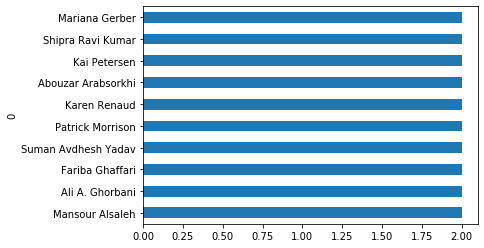

In [7]:
auth_col_list = list(df.columns[:6])
authdf = pd.DataFrame(df[auth_col_list])
authindex = pd.DataFrame(authdf.stack())
authindex.groupby([0]).size().sort_values().tail(10).plot(kind='barh')
#auth_series = pd.Series(df[auth_col_list].values.ravel()).dropna()
#auth_series

In [8]:
df.columns

Index(['author0', 'author1', 'author2', 'author3', 'author4', 'author5',
       'keywords0', 'keywords1', 'keywords10', 'keywords11', 'keywords12',
       'keywords13', 'keywords14', 'keywords15', 'keywords16', 'keywords17',
       'keywords18', 'keywords19', 'keywords2', 'keywords20', 'keywords21',
       'keywords3', 'keywords4', 'keywords5', 'keywords6', 'keywords7',
       'keywords8', 'keywords9', 'database', 'title', 'journal', 'citations',
       'year', 'impact_factor'],
      dtype='object')

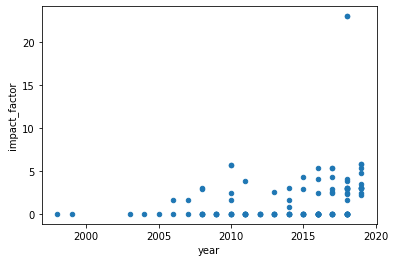

In [9]:
# Scatterplot
# X: highest impact factor
# Y: Impact factor, ascending

df[["impact_factor", "year"]].plot(kind='scatter', x='year', y='impact_factor')

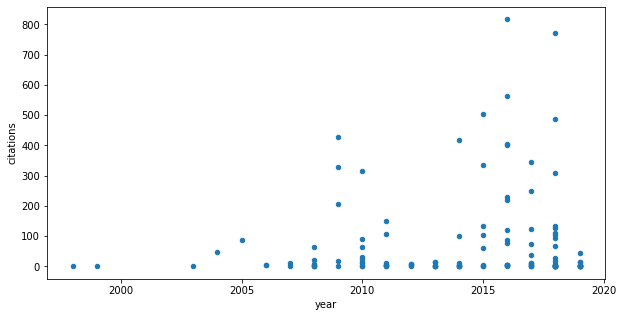

In [10]:
# Scatterplot citations and year
# X: year
# Y: Citations

df[["citations", "year"]].plot(kind='scatter', x='year', y='citations', figsize=(10,5))

In [70]:
# New DataFrame ONLY REAL Papers
ndf = df[["citations", "title", "journal", "database", "year", "impact_factor"]]
df.loc[df["impact_factor"] > 0].sort_values(by="citations", ascending=False)

,author0,author1,author2,author3,author4,author5,keywords0,keywords1,keywords10,keywords11,...,keywords6,keywords7,keywords8,keywords9,database,title,journal,citations,year,impact_factor
10,Marco Angelini,Graziano Blasilli,Tiziana Catarci,Simone Lenti,Giuseppe Santucci,NaN,Security,Bars,Attack Graph,Vulnerability triage and management,...,Network security,Vulnerability analysis,CVE,CVSS,ieeexplore,Vulnus: Visual Vulnerability Analysis for Netw...,IEEE Transactions on Visualization and Compute...,486,2018,3.780
108,Kai Petersen,Sairam Vakkalanka,Ludwik Kuzniarz,NaN,NaN,NaN,Systematic mapping studies,Software engineering,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Guidelines for conducting systematic mapping s...,Information and Software Technology,334,2015,2.921
24,Hadi Shiravi,Ali Shiravi,Ali A. Ghorbani,NaN,NaN,NaN,Data visualization,Security,NaN,NaN,...,IP networks,Information visualization,network security visualization,visualization techniques.,ieeexplore,A Survey of Visualization Systems for Network ...,NaJ,107,2011,3.780
102,Ulrik Franke,Joel Brynielsson,NaN,NaN,NaN,NaN,Situational awareness,Cyber security,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Cyber situational awareness – A systematic rev...,Computers & Security,102,2014,3.062
80,Daniel Mellado,Carlos Blanco,Luis E. Sánchez,Eduardo Fernández-Medina,NaN,NaN,Security requirements,Security requirements engineering,NaN,NaN,...,Systematic review,NaN,NaN,NaN,sciencedirect,A systematic review of security requirements e...,Computer Standards & Interfaces,92,2010,2.441
137,Minhaj Ahmad Khan,NaN,NaN,NaN,NaN,NaN,Cloud security,Cloud computing,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,A survey of security issues for cloud computing,Journal of Network and Computer Applications,77,2016,5.273
31,Ashish Singh,Kakali Chatterjee,NaN,NaN,NaN,NaN,Cloud computing,Cloud framework,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Cloud security issues and challenges: A survey,Journal of Network and Computer Applications,73,2017,5.273
84,Omar H. Alhazmi,Yashwant K. Malaiya,NaN,NaN,NaN,NaN,Operating systems,Security,Operating systems,security,...,Linux,Software systems,Life testing,System testing,ieeexplore,Application of Vulnerability Discovery Models ...,IEEE Transactions on Reliability,64,2008,2.888
132,Noam Ben-Asher,Cleotilde Gonzalez,NaN,NaN,NaN,NaN,Cyber security,Knowledge,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Effects of cyber security knowledge on attack ...,Computers in Human Behavior,61,2015,4.306
134,Wenjun Xiong,Robert Lagerström,NaN,NaN,NaN,NaN,Threat modeling,Literature review,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Threat modeling – A systematic literature review,Computers & Security,46,2019,3.062


In [12]:
df.sort_values(by="citations", ascending=False)

,author0,author1,author2,author3,author4,author5,keywords0,keywords1,keywords10,keywords11,...,keywords6,keywords7,keywords8,keywords9,database,title,journal,citations,year,impact_factor
126,Mahesh Bang,Himanshu Saraswat,NaN,NaN,NaN,NaN,Security,Internet,Security Training,DAST,...,Business,Application Security,Web Application Security Assessment,Security Metrics,ieeexplore,Building an effective and efficient continuous...,2016 International Conference On Cyber Situati...,817,2016,0.000
130,Hussain Aldawood,Geoffrey Skinner,NaN,NaN,NaN,NaN,Organizations,Phishing,NaN,NaN,...,cyber security awareness,information security awareness,NaN,NaN,ieeexplore,Educating and Raising Awareness on Cyber Secur...,NaJ,773,2018,0.000
50,Ed Pearson,Cindy L. Bethel,NaN,NaN,NaN,NaN,Computer security,Software,information security,cyber security,...,SQL injection attack mitigation,SQL injection attack prevention,Human-computer interaction,software security,ieeexplore,A design review: Concepts for mitigating SQL i...,2016 4th International Symposium on Digital Fo...,562,2016,0.000
76,Bessy Mahopo,Hanifa Abdullah,Mathias Mujinga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ieeexplore,A formal qualitative risk management approach ...,2015 Information Security for South Africa (ISSA),503,2015,0.000
10,Marco Angelini,Graziano Blasilli,Tiziana Catarci,Simone Lenti,Giuseppe Santucci,NaN,Security,Bars,Attack Graph,Vulnerability triage and management,...,Network security,Vulnerability analysis,CVE,CVSS,ieeexplore,Vulnus: Visual Vulnerability Analysis for Netw...,IEEE Transactions on Visualization and Compute...,486,2018,3.780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Iman Sharafaldin,Arash Habibi Lashkari,Ali A. Ghorbani,NaN,NaN,NaN,Information visualization,Network attacks,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,An evaluation framework for network security v...,Computers & Security,1,2019,3.062
89,Michael Ettredge,Feng Guo,Yijun Li,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Trade secrets and cyber security breaches,Journal of Accounting and Public Policy,0,2018,2.269
16,Orestis Mavropoulos,Haralambos Mouratidis,Andrew Fish,Emmanouil Panaousis,NaN,NaN,IoT Security,Security requirements,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Apparatus: A framework for security analysis i...,Ad Hoc Networks,0,2019,3.490
85,Yang Lu,Minghui Zhu,NaN,NaN,NaN,NaN,Cyber-physical systems,Privacy,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,A control-theoretic perspective on cyber-physi...,Annual Reviews in Control,0,2019,4.759


In [15]:
list(df.columns[0:6])

['author0', 'author1', 'author2', 'author3', 'author4', 'author5']

In [16]:
# Melting all author columns into one column
melt_auth_df = df[list(df.columns[0:6])].melt(var_name='auth_id').set_index('auth_id')
melt_auth_df.dropna().groupby('value').size().sort_values(ascending=False)

value
Mariana Gerber         2
Shipra Ravi Kumar      2
Kai Petersen           2
Abouzar Arabsorkhi     2
Karen Renaud           2
                      ..
Nebojša Gvozdenović    1
Neeraj Kumar           1
Nicolas Vavasseur      1
Noam Ben-Asher         1
A. Hunstad             1
Length: 350, dtype: int64

**Keywords**

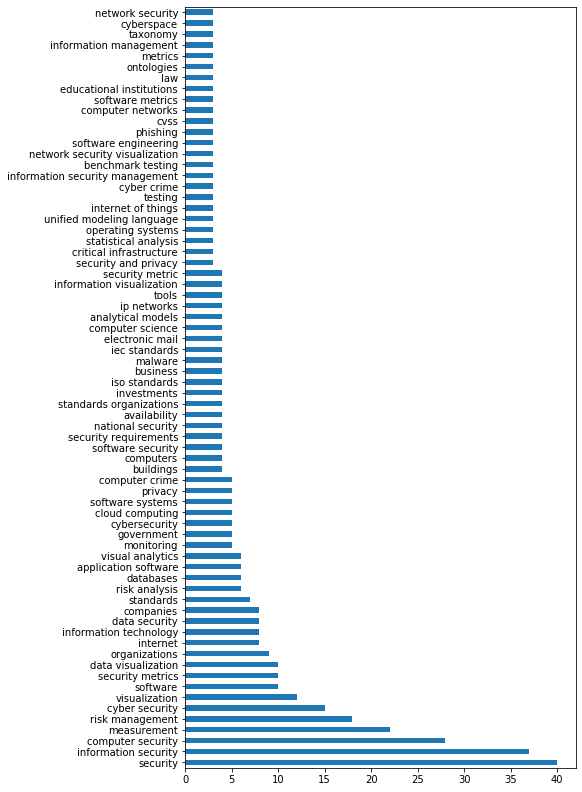

In [17]:
# Get the most used keywords

# Combine the keywordcolumns into one series
#Melting!!
# Search for the most used one 

melt_key = df[list(df.columns[6:28])].melt().drop("variable", axis=1)
melt_df = melt_key["value"].dropna().str.lower()
melt_df.value_counts().head(70).plot(kind='barh', figsize=(7, 14))
#melt_70_dict = melt_df.value_counts().head(70).to_dict()

#WordCloud(background_color="black").generate_from_frequencies(frequencies=melt_70_dict)

#melt_df.plot(kind='barh', figsize=(7, 14))
#.groupby("value").size().sort_values(ascending=False).head(50).plot(kind='barh', figsize=(7,12))

In [18]:
keywords_count = melt_df.value_counts()
keywords_count.head(50)


# Show all keywords that contain 'security'
def show_keywords_with_security_in_them(series,search_pattern):
    for elem in series:
        if search_patter in elem:
            print(elem)
        else:
            continue

# Show all keywords that contain 'security' not at the start
# At least once character must be before 'security'

# Regex security not at first position
def keywords_security_not_at_first_pos(series, search_pattern):
    re_sec = re.compile(r'.+security')
    for elem in series:
        if re_sec.search(elem):
            print(elem)
        else:
            continue
        
# Get it-security and it security and combine them into one
# get the corresponding value and add them up
# remove whitespaces and seperating spaces.
# Then add up again
melt_key = df[list(df.columns[6:28])].melt().drop("variable", axis=1)
melt_df = melt_key["value"].dropna().str.lower()
melt_rep_df = melt_df.str.replace(' ', '').str.replace('-', '')
# melt_rep_df.value_counts().head(70).plot(kind='barh', figsize=(7,14))

In [19]:
# Words to count together
# security metric & security metrics & metrics & metrics
sec_met_words = ['security metric', 'security metrics', 'metric', 'metrics']
# get all needed rows to combine
# 

m_values = melt_df.value_counts()
def find_all_values_in_df(word_list, some_df):
    found_elem = []
    for elem in word_list:
        f_elem = some_df.loc[elem]
        found_elem.append(f_elem)
    return found_elem

def delete_index_in_df(word_list, some_df):
    return some_df.drop(word_list)

sec_mec_counts = find_all_values_in_df(sec_met_words, m_values)
without_sec_mec = delete_index_in_df(sec_met_words, m_values)
without_sec_mec
# Get positions of words and values
# delete positions
# create new position 'security metrics'


security                   40
information security       37
computer security          28
measurement                22
risk management            18
                           ..
cybersa                     1
mathematical model          1
data breaches               1
cvss version2               1
network attack taxonomy     1
Name: value, Length: 625, dtype: int64

In [63]:
df.loc[df["database"].eq('sciencedirect') & df["journal"].eq("Computers & Security")]

,author0,author1,author2,author3,author4,author5,keywords0,keywords1,keywords10,keywords11,...,keywords6,keywords7,keywords8,keywords9,database,title,journal,citations,year,impact_factor
1,Mariana Gerber,Rossouw von Solms,NaN,NaN,NaN,NaN,Information security,Information security management,NaN,NaN,...,Compliance,NaN,NaN,NaN,sciencedirect,Information security requirements – Interpreti...,Computers & Security,21,2008,3.062
9,Margaret Gratian,Sruthi Bandi,Michel Cukier,Josiah Dykstra,Amy Ginther,NaN,Human factors,Individual differences,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Correlating human traits and cyber security be...,Computers & Security,8,2018,3.062
46,Ivano Bongiovanni,NaN,NaN,NaN,NaN,NaN,Information security management,Cybersecurity,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,The least secure places in the universe? A sys...,Computers & Security,14,2019,3.062
48,Wiem Tounsi,Helmi Rais,NaN,NaN,NaN,NaN,Technical threat intelligence,Indicators of compromise (IOC),NaN,NaN,...,Cyber crime,Preventative strategies,Risk analysis,Threat sharing,sciencedirect,A survey on technical threat intelligence in t...,Computers & Security,19,2018,3.062
54,Karen Renaud,Stephen Flowerday,Merrill Warkentin,Paul Cockshott,Craig Orgeron,NaN,Cyber security,Responsibilization,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Is the responsibilization of the cyber securit...,Computers & Security,2,2018,3.062
83,Rajendra Patil,Harsha Dudeja,Chirag Modi,NaN,NaN,NaN,Cloud computing,Virtual network security,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Designing an efficient security framework for ...,Computers & Security,1,2019,3.062
102,Ulrik Franke,Joel Brynielsson,NaN,NaN,NaN,NaN,Situational awareness,Cyber security,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Cyber situational awareness – A systematic rev...,Computers & Security,102,2014,3.062
112,Mansour Alali,Ahmad Almogren,Mohammad Mehedi Hassan,Iehab A.L. Rassan,Md Zakirul Alam Bhuiyan,NaN,Cyber security,Cybercrime,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Improving risk assessment model of cyber secur...,Computers & Security,6,2018,3.062
133,Matias Dodel,Gustavo Mesch,NaN,NaN,NaN,NaN,Cyber-safety,Preventive behavior,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,An integrated model for assessing cyber-safety...,Computers & Security,6,2019,3.062
134,Wenjun Xiong,Robert Lagerström,NaN,NaN,NaN,NaN,Threat modeling,Literature review,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Threat modeling – A systematic literature review,Computers & Security,46,2019,3.062


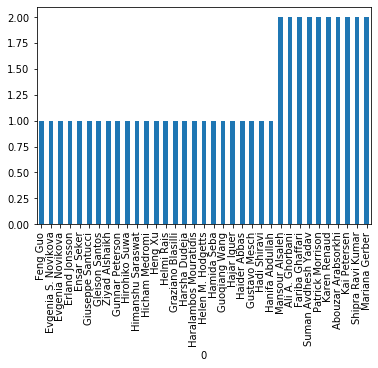

In [20]:
# Number of studies per author
# Most published authors
# extracting the authorcolumns from the df
auth_col_list = list(df.columns[:6])
authdf = pd.DataFrame(df[auth_col_list])
authindex = pd.DataFrame(authdf.stack())
authindex.groupby([0]).size().sort_values().tail(35).plot(kind='bar')
#auth_series = pd.Series(df[auth_col_list].values.ravel()).dropna()
#auth_series

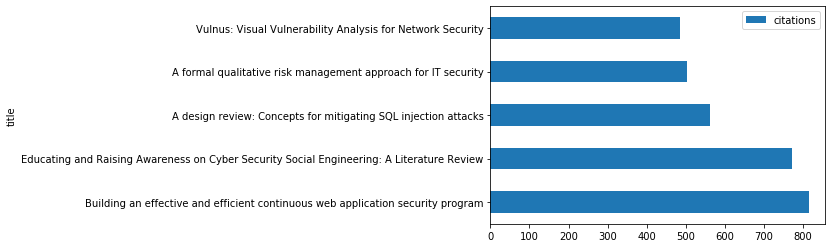

In [21]:
# Most cited paper plus distribution of citations
df[["citations", "title"]].sort_values(
    by="citations",
    ascending=False).head().set_index('title').plot(kind='barh')

In [22]:
df[["citations", "title"]].sort_values(by="citations",
                                      ascending=False)

,citations,title
126,817,Building an effective and efficient continuous...
130,773,Educating and Raising Awareness on Cyber Secur...
50,562,A design review: Concepts for mitigating SQL i...
76,503,A formal qualitative risk management approach ...
10,486,Vulnus: Visual Vulnerability Analysis for Netw...
...,...,...
141,1,An evaluation framework for network security v...
89,0,Trade secrets and cyber security breaches
16,0,Apparatus: A framework for security analysis i...
85,0,A control-theoretic perspective on cyber-physi...


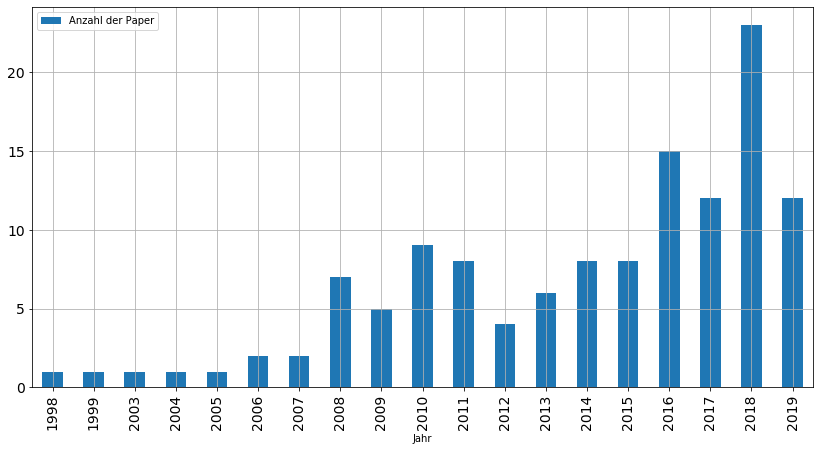

In [23]:
# Time series corelation. x: tiem in years, y: number of studies
time_correlation_gby = df.groupby("year").size()
time_corr_df = pd.DataFrame(time_correlation_gby)
time_corr_df.columns = ['Anzahl der Paper']
time_corr_df.index.name = 'Jahr'
time_corr_df.plot(kind='bar', figsize=(14, 7), grid=True, fontsize=14)

In [24]:
# Get a listing of published papers per yea
df.groupby("year").size().sort_values(ascending=False)

year
2018    23
2016    15
2019    12
2017    12
2010     9
2014     8
2011     8
2015     8
2008     7
2013     6
2009     5
2012     4
2007     2
2006     2
2005     1
2004     1
2003     1
1999     1
1998     1
dtype: int64

In [25]:
# 2010 stand out here, so have a look which Papers were published then
df.loc[df["year"] == 2010, ["year", "title", "database"]]

,year,title,database
15,2010,Why Measuring Security Is Hard,ieeexplore
34,2010,Information Security Threats Classification Py...,ieeexplore
77,2010,NetVis: A network security management visualiz...,ieeexplore
80,2010,A systematic review of security requirements e...,sciencedirect
91,2010,Vulnerability Analysis in SOA-Based Business P...,ieeexplore
93,2010,Introducing a framework for security measurements,ieeexplore
98,2010,An expert system for security diagnosing of co...,ieeexplore
123,2010,Expert-Aware Approach: A New Approach to Impro...,ieeexplore
139,2010,A Formal Approach Enabling Risk-Aware Business...,ieeexplore


In [64]:
database_by_year

,IEEE Xplore,ScienceDirect
Jahr,,
1998,1.0,0.0
1999,1.0,0.0
2003,1.0,0.0
2004,1.0,0.0
2005,1.0,0.0
2006,2.0,0.0
2007,2.0,0.0
2008,6.0,1.0
2009,5.0,0.0


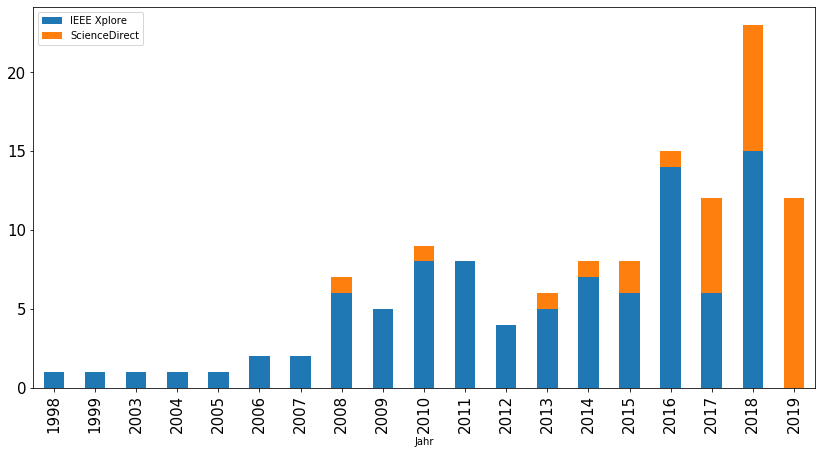

In [65]:
# Which are the most cited datqabases per year
index_names = ["Jahr", "Datenbank"]
grp_by_year_db = df.groupby(["year", "database"]).size()
grp_by_year_db.index.names = index_names
database_by_year = grp_by_year_db.unstack().fillna(0)
database_by_year.columns = ["IEEE Xplore", "ScienceDirect"]
database_by_year.plot(kind='bar', stacked=True, figsize=(14,7), fontsize=15)

In [27]:
database_by_year

,IEEE Xplore,ScienceDirect
Jahr,,
1998,1.0,0.0
1999,1.0,0.0
2003,1.0,0.0
2004,1.0,0.0
2005,1.0,0.0
2006,2.0,0.0
2007,2.0,0.0
2008,6.0,1.0
2009,5.0,0.0


In [28]:
# Journal types. Journals of Conference

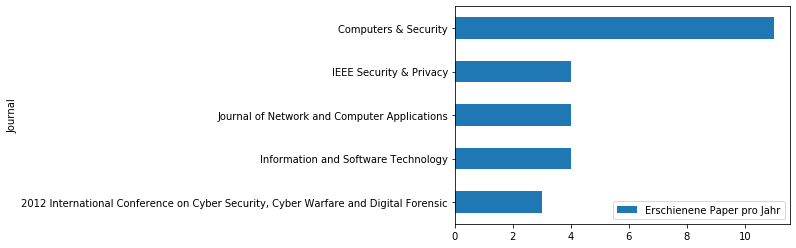

In [29]:
# Most published journals. Dropping all values with NotaJournal entry
df.loc[df["journal"].eq('Proceedings Title: 2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic (CyberSec)'), "journal"] = "2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic"
journal_gby = df.groupby("journal").size().drop('NaJ').sort_values().tail(5)
journal_time_journal_df = journal_gby.reset_index()
journal_time_journal_df.columns = ["Journal", "Erschienene Paper pro Jahr"]
journal_time_journal_df.set_index("Journal").plot(kind='barh')
# journal_plot = journal_time_journal_df.set_index("Journal").plot(kind='barh')

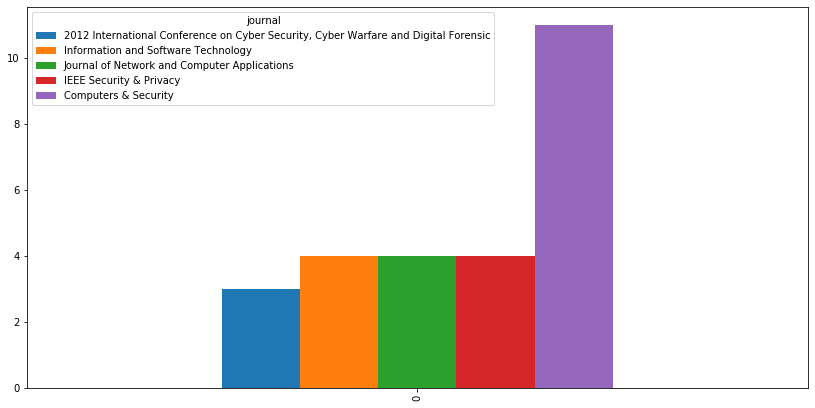

In [30]:
# Most published journals.

# Get the dataframe
# Get the amount of journals. Probably groupby
grp_journal = df.groupby("journal").size().drop('NaJ').sort_values().tail(5)
grp_journal_amount = pd.DataFrame(grp_journal.reset_index().unstack().unstack())
grp_journal_amount.columns = grp_journal_amount.loc["journal"]
grp_journal_amount.drop(grp_journal_amount.index[0]).plot(kind='bar', figsize=(14,7))

In [31]:
input_df = pd.DataFrame(grp_journal.reset_index())
new_cols = input_df["journal"].values
type(new_cols)

numpy.ndarray

,"2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic",Information and Software Technology,Journal of Network and Computer Applications,IEEE Security & Privacy,Computers & Security
0,3.0,NaN,NaN,NaN,NaN
1,NaN,4.0,NaN,NaN,NaN
2,NaN,NaN,4.0,NaN,NaN
3,NaN,NaN,NaN,4.0,NaN
4,NaN,NaN,NaN,NaN,11.0


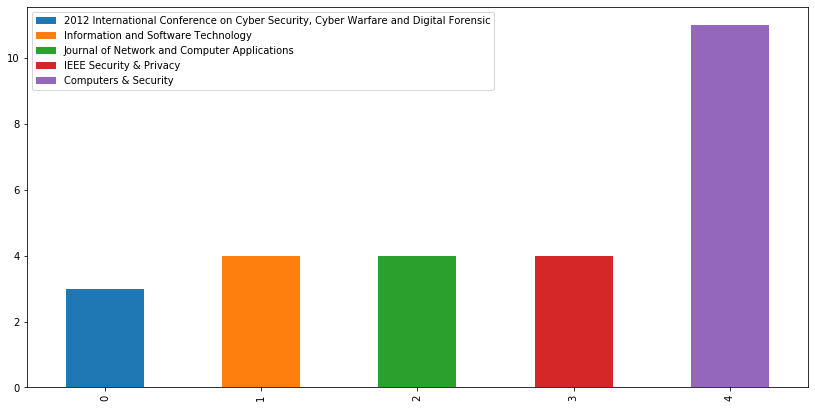

In [32]:
def values_into_main_diagonal(some_series, new_cols):
    """Puts the values of a series onto the main diagonal of a new df"""
    x = [{i: some_series[i]} for i in range(len(some_series))]
    main_diag_df = pd.DataFrame(x)
    main_diag_df.columns = new_cols
    return main_diag_df

# Saving the index for later new column labels
stack_df = pd.DataFrame(values_into_main_diagonal(input_df[0], new_cols))
stack_df.plot(kind='bar', stacked=True, figsize=(14,7))
stack_df

In [33]:
grp_j

NameError: name 'grp_j' is not defined

In [34]:
grp_journal_amount

journal,"2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic",Information and Software Technology,Journal of Network and Computer Applications,IEEE Security & Privacy,Computers & Security
journal,2012 International Conference on Cyber Securit...,Information and Software Technology,Journal of Network and Computer Applications,IEEE Security & Privacy,Computers & Security
0,3,4,4,4,11


In [35]:
# Stack Overflowquestion answer
s_df = pd.DataFrame(grp_journal.reset_index().unstack().unstack())
s_df
# Capturing the journals row
new_cols = s_df.values[0]
s_df.values





array([['2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic',
        'Information and Software Technology',
        'Journal of Network and Computer Applications',
        'IEEE Security & Privacy', 'Computers & Security'],
       [3, 4, 4, 4, 11]], dtype=object)

In [39]:
def values_to_main_diagonal(one_row_df, column_labels):
    """Returns a Dataframe, were the values from a """
    x = [{i: one_row_df.values[0][i]} for i in range(len(one_row_df.columns))]
    main_diagonal_df = pd.DataFrame(x)
    main_diagonal_df.columns = column_labels
    
one_row_df = grp_journal_amount.drop(grp_journal_amount.index[0])
one_row_cols = one_row_df.columns
x_df = values_to_main_diagonal(one_row_df)

#main_diagonal_df = pd.DataFrame(x)
#main_diagonal_df.columns = one_row_cols
#main_diagonal_df.plot(kind='bar', stacked=True, figsize=(14,7))


TypeError: values_to_main_diagonal() missing 1 required positional argument: 'column_labels'

In [40]:
list(range(5))

[0, 1, 2, 3, 4]

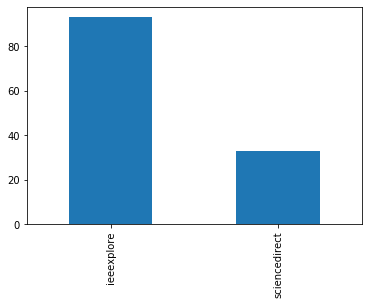

In [41]:
# Found papers in databases
used_databases = df["database"].value_counts()
used_databases.plot(kind='bar')

In [42]:
used_databases.to_csv('test.csv')

/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [43]:
# Found conference papers. Usually withour an impact factor

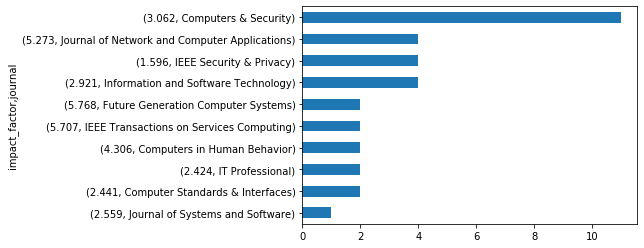

In [44]:
# Shows impact factors and journals that are most commonly used
df.groupby(["impact_factor", "journal"]).size().drop(0.000).sort_values().tail(
10).plot(kind='barh')

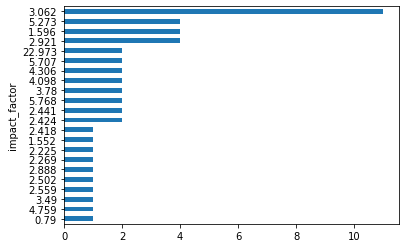

In [45]:
# Show highest impactfactors and journals used
# df.loc[:, ["journal", "impact_factor"]].sort_values(by="impact_factor").tail(18)
df.groupby("impact_factor").size().drop(0.000).sort_values().plot(kind='barh')

In [46]:
import random

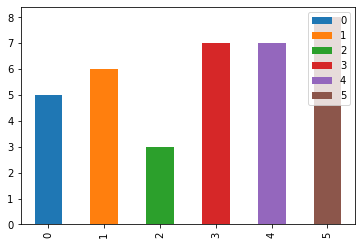

In [47]:
x = [{i:random.randint(1,10)} for i in range(6)]
tdf = pd.DataFrame(x)
tdf.plot(kind='bar', stacked=True)

In [48]:
tdf

,0,1,2,3,4,5
0,5.0,NaN,NaN,NaN,NaN,NaN
1,NaN,6.0,NaN,NaN,NaN,NaN
2,NaN,NaN,3.0,NaN,NaN,NaN
3,NaN,NaN,NaN,7.0,NaN,NaN
4,NaN,NaN,NaN,NaN,7.0,NaN
5,NaN,NaN,NaN,NaN,NaN,8.0
